# 1. DATA EXPLORATION

In my Data Exploration, I plotted all the coliumn distributions, created a correlation matrix, and listed absolute correlations. I found sentiment related variables were most highly correlated, and decided to move forward in doing feature extraction via Vader and Tfidf. 

The Target (Score) distribution exhibits a strong skew toward the top class (e.g., 5‑star), motivating class‑imbalance handling.
Text fields have wide variance in length; some missing/empty; presence of emojis, capitalization, punctuation emphasis, and occasional sarcasm. Meta/activity echibits repeated reviewers & products—useful signals via review counts (reviewer/product/artist).
Votes & times exhibit heavy‑tailed vote counts; unix timestamps converted to years/months/dow; seasonal/recency patterns.
There are outliers in votes and text length; sparse genres; inconsistent helpfulness fields. I kept text as primary signal; complement with lightweight numeric features. I also guarded against leakages by having no target‑derived features (like mean Score in my previous midterm); time‑based features are descriptive, not predictive of label generation. I used log transforms for skewed counts across all variables, they generally exhibit higher correlation with score.


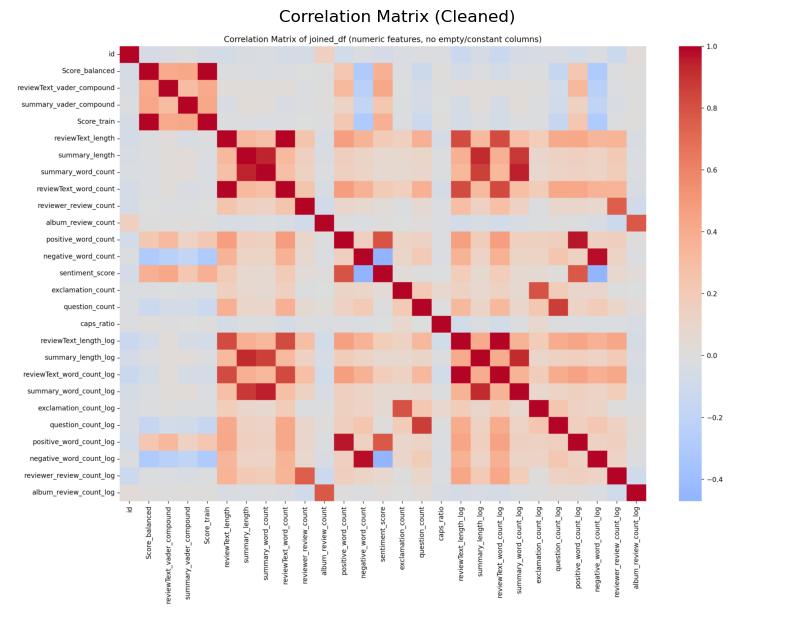

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("corr_matrix_cleaned.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Correlation Matrix (Cleaned)")
plt.show()

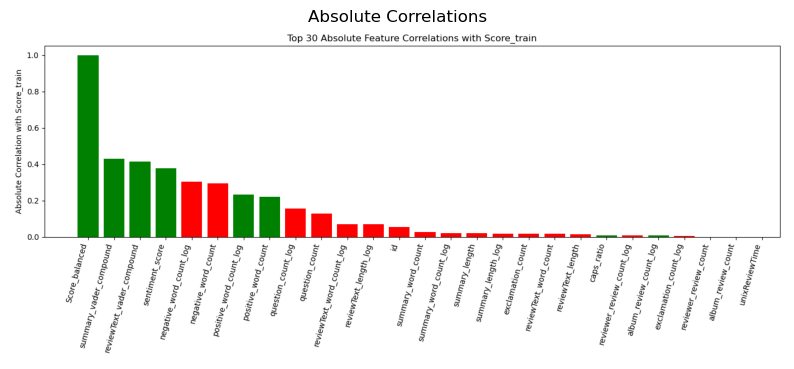

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("abscorr.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Absolute Correlations")
plt.show()

# 2. FEATURE EXTRACTION / ENGINEERING

I started simple, doing Tfidf with a generalizable logistic regression and building out. I orignally began with the following features: 

Index(['id', 'album_mbid', 'reviewerID', 'summary', 'reviewText', 'Score',
       'genres', 'artist_mbid', 'unixReviewTime', 'VotedHelpful', 'TotalVotes',
       'reviewText_length', 'summary_length', 'summary_word_count',
       'reviewText_word_count', 'helpfulness_ratio', 'has_votes',
       'review_date', 'review_year', 'review_month', 'review_day_of_week',
       'num_genres', 'reviewer_review_count', 'album_review_count',
       'artist_review_count', 'reviewText_lower', 'positive_word_count',
       'negative_word_count', 'sentiment_score', 'exclamation_count',
       'question_count', 'caps_ratio', 'reviewText_length_log',
       'summary_length_log', 'reviewText_word_count_log',
       'summary_word_count_log', 'exclamation_count_log', 'question_count_log',
       'positive_word_count_log', 'negative_word_count_log',
       'VotedHelpful_log', 'TotalVotes_log', 'reviewer_review_count_log',
       'album_review_count_log', 'artist_review_count_log'],

Upon running the log model to make sure it is a good fit, I used a scheduler to help guide my parameters for Tfidf. I used reviewText and Summary as my primary columns. The practical defaults that were found to be robust are 

ngram_range=(1,2) (unigrams + bigrams)
min_df∈{2,5} to remove ultra‑rare tokens
max_df∈{0.7,0.9} to drop corpus‑stopwords/boilerplate

For numeric features, I used: 

Length & counts: reviewText_length, reviewText_word_count, summary_length, summary_word_count.
Punctuation: exclamation_count, question_count, caps ratio.
Helpfulness: VotedHelpful, TotalVotes, helpfulness_ratio = VotedHelpful/(TotalVotes+1).
Log transforms: Apply log1p to skewed counts (votes, activity, punctuation).
Activity: reviewer_review_count, album_review_count, artist_review_count (+ log).
Time: review_year, review_month, day_of_week.
NaN policy: Fill missing with safe defaults (0 or empty), consistent with model expectations.

My key insights were:

TF‑IDF dominates raw predictive power; n‑grams (especially bigrams) consistently help.
VADER compound aligns strongly with high vs. low scores and adds stability for very short reviews.
Log transforms tame heavy tails and make LR optimization easier.
Activity features are useful, but keep them compact to avoid overfitting to prolific entities.


In terms of feature elimination, I used a stepwise approach, removing features one by one while keeping other parameters constant.  

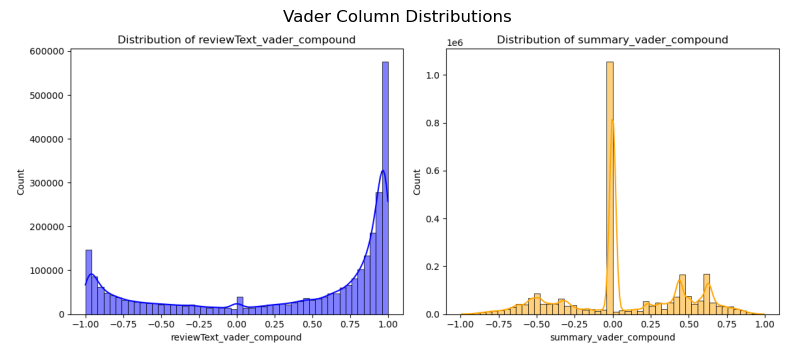

In [9]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("vader_distr.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Vader Column Distributions")
plt.show()

# 3. MODEL CREATION AND ASSUMPTIONS

3.1 Core pipeline

Algorithm: LogisticRegression (LBFGS, L2), chosen for strong performance, speed, and interpretability on sparse TF‑IDF.
Text‑only baseline: TF‑IDF → LR as a high bar.
Text + numeric: Either concatenate via ColumnTransformer or (if keeping things simple) append numeric features into a separate pipeline branch.

3.2 Imbalance handling

Observed skew: Majority class dominates (e.g., 5‑star).
I used two strategies:

Resampling: Downsample majority to ~80% of its size; upsample each minority toward a target (e.g., 80–90% of post‑downsample majority).
Class weights: class_weight='balanced' as a fast alternative when resampling is too heavy.

3.3 Validation

Stratified CV (e.g., 3‑ or 5‑fold) with consistent random seeds.
Metric focus: macro-F1 (to reflect minority performance), plus accuracy for reference.

I choose to mimic the kaggle test/split of 70/30. 

Insights

LR on TF‑IDF is a strong, fast baseline.
Resampling/class weights materially improve minority recall vs a naive model.
Keeping the pipeline simple and debuggable sped up iteration dramatically.

I experminented with both a random forest and logistic regression, ultimately moving forward with a logistic regression.

- Excels with high-dimensional, sparse data (like TF‑IDF text features).  
- Fast to train, interpretable coefficients, robust to collinearity.  
- Assumes linear relationship between features and log-odds of the outcome.  
- Assumes independence of observations and little multicollinearity.

**Why Random Forest?**  
- Handles nonlinear relationships and feature interactions automatically.  
- Robust to outliers, missing values, and noisy features.  
- Makes fewer assumptions about feature distributions; works well with mixed numeric/categorical data.  
- Assumes samples are independent; can overfit if trees are too deep or data is highly imbalanced.

Both models are strong baselines: LR for interpretability and speed, RF for capturing complex patterns and interactions.


A key assumption is that sentiment is a good predictor. Via the Tfidf results, this aligns with the assumption:

Top + features for class '1.0':
waste                                 4.0441
money                                 3.1203
boring                                2.6988
worst                                 2.4282


Top - features for class '1.0':
great                                -1.9489
good                                 -1.9335


Top + features for class '2.0':
two stars                             3.3640
boring                                2.5008
too                                   2.2904

Top - features for class '2.0':
sentiment_score                      -1.8910
fun                                  -1.8886
great                                -1.5069


Top + features for class '3.0':
but                                   3.2718
okay                                  3.0819
ok                                    3.0475


Top - features for class '3.0':
this                                 -2.3643
exclamation_count_log                -1.7058
waste                                -1.6317

Top + features for class '4.0':
good                                  3.0947
fun                                   2.1138
enjoyed                               2.0512


Top - features for class '4.0':
boring                               -2.2041
waste                                -2.1923
acting                               -1.6756
not                                  -1.5648


Top + features for class '5.0':
great                                 3.7867
loved                                 2.5633
awesome                               2.4948
excellent                             2.3381


Top - features for class '5.0':
but                                  -4.2616
not                                  -3.4532
didn                                 -2.8726


# 4. MODEL TUNING

4.1 One‑at‑a‑time scheduler (fast & interpretable)

For each parameter in TFIDF_PARAMS and LR_PARAMS, we:

Hold all others constant at defaults.
Sweep the parameter values.
Compute CV score (e.g., macro‑F1).
Plot parameter value vs performance.


Why: Gives intuition on shape (U‑shapes, plateaus) and useful ranges with minimal compute.

Typical behaviors we observed

tfidf__ngram_range: (1,2) > (1,1); (1,3) increases compute & variance with minor gains.
tfidf__min_df: Small increases (1→2→5) reduce noise & overfitting; too aggressive drops useful rare terms.
tfidf__max_df: 0.9 often beats 1.0 by removing boilerplate; going <0.7 starts removing informative tokens.
lr__C: U‑shaped curve; moderate regularization (C around 1–4 range) generally best.

4.2 Compact final grid search

After identifying ranges with the scheduler, we:

Grid‑searched a small box (e.g., C∈{1,2,4}, min_df∈{2,5}, max_df∈{0.7,0.9}, ngram∈{(1,1),(1,2)}).
Kept CV folds low (3) to run quickly; used macro‑F1.

Insights

Scheduler curves prevented “blind” grid searches and reduced runs by an order of magnitude.
The best settings generalized across folds and splits—stable optima.


5) MODEL EVALUATION
5.1 What we report

Primary: Macro‑F1 (class balance), per‑class precision/recall.
Secondary: Accuracy, micro‑F1, confusion matrix.
Diagnostics: Learning curves (data sufficiency), calibration (optional), and coefficient inspection (top TF‑IDF weights).

5.2 Key qualitative outcomes

Balanced improvements after resampling/class‑weighting—macro‑F1 rises (especially for mid/low scores).
Misclassifications typically off by only one class (e.g., 3 vs 4), indicating reasonable ordinal behavior.
Top positive terms (e.g., “excellent”, “love”, “highly recommend”) pull toward high scores; negative terms (e.g., “disappointed”, “terrible”) pull toward low scores—good face validity.
VADER compound consistently ranks among the top non‑text features.

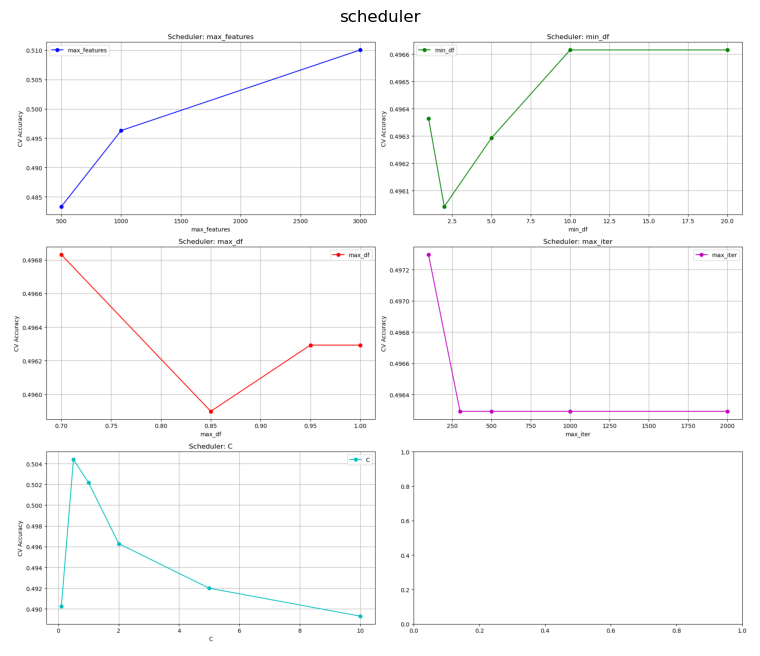

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("scheduler.png")
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("scheduler")
plt.show()

# 5. MODEL EVALUATION / PERFORMANCE

TF‑IDF (how)

Applied to reviewText (and optionally summary) inside the pipeline.
Tuned ngram_range, min_df, max_df using the scheduler; finalized with a compact grid.
Logistic Regression consumes the sparse matrix directly (no dense expansion).

TF‑IDF insights

Text is the single strongest signal; bigrams add meaningful context.
Filtering (min_df, max_df) is crucial for reducing noise & compute.
The top coefficients are intuitive and explain predictions to stakeholders.

VADER (how)

Computed sentiment compound (and optionally pos/neg/neu) for reviewText and summary.
Added as numeric features alongside TF‑IDF and engineered features.

VADER insights

Strong correlation with star ratings; improves minority‑class recall.
Complements TF‑IDF—it captures consistent polarity even when n‑grams are sparse (very short reviews).
Edge cases remain (sarcasm, mixed tone), but net effect is positive and stable.

Log variables performed consistently better. 

A logistic regression weight of 1 seemed to be the sweet spot. Increasing max_features also increased accuracy while increasing max_df, min_df, and iterations has limited gains. 

# 6. STRUGGLES / ISSUES / OPEN QUESTIONS


Class imbalance: Without resampling or class weights, the model collapses to the majority class. Resampling was effective yet kept training fast.
Skewed counts: Votes & activity needed log1p transforms; untransformed, they destabilized training.
Text noise: Misspellings and sarcasm remain tricky; TF‑IDF+VADER mitigates but doesn’t solve them.

A very large issue I had was compute time. Models ran from 20 minutes to indefinetly. I chose grid search instead of a full scheduler due to this time constraint. 